In [36]:
from tslearn.shapelets import ShapeletModel
#from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
from tslearn.preprocessing import TimeSeriesScalerMinMax

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#from pyts.transformation import ShapeletTransform
#from pyts.classification import LearningShapelets

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import ast

# Reading DF from .csv

In [37]:
daily_stats = pd.read_csv('../daily_stats_user.csv', lineterminator='\n', index_col=0)

##### Converting str time series into array

In [38]:
daily_stats['success_ts'] = daily_stats.success_ts.apply(ast.literal_eval)

#### TSs formatting 

In [39]:
X_bot = []
y_bot = []

X_nonbot = []
y_nonbot = []

X_class = []

for row in daily_stats.itertuples():
    if row.bot == 1:
        X_bot.append(row.success_ts)
        y_bot.append(row.bot)
    elif row.bot == 0:
        X_nonbot.append(row.success_ts)
        y_nonbot.append(row.bot)
    else:
        X_class.append(row.success_ts)

X = X_bot + X_nonbot
y = y_bot + y_nonbot


### "Manually extracting" shapelets

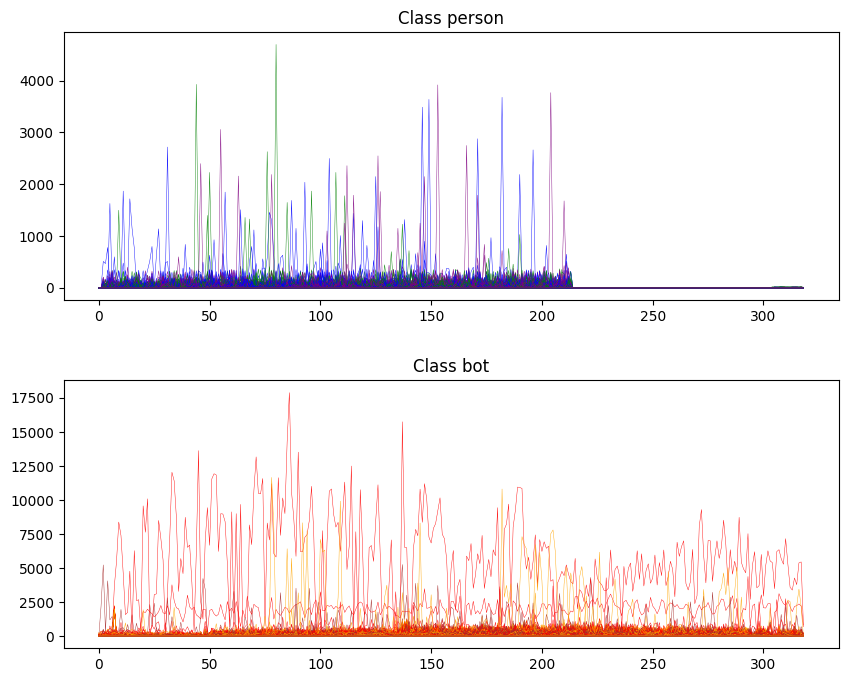

In [40]:
fig, ax =  plt.subplots(2, figsize=(10, 8))
botcol = ['orange', 'brown', 'red']
pplcol = ['green', 'blue', 'purple']

for i in range(len(X)):
    if y[i] == 0:
        ax[0].plot(X[i], color=random.choice(pplcol), linewidth=0.3)
    else:
        ax[1].plot(X[i], color=random.choice(botcol), linewidth=0.3)

ax[0].set_title('Class person')
ax[1].set_title('Class bot')

fig.subplots_adjust(hspace=0.3)
fig.savefig('Classess.png')

# ShapeletModel creation, training, test and classificaton 

##### Splitting the TSs into traing and test sets

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

##### TSs normalization

In [42]:

X_train_norm = TimeSeriesScalerMinMax(value_range=(0., 1.)).fit_transform(X_train)
X_test_norm = TimeSeriesScalerMinMax(value_range=(0., 1.)).fit_transform(X_test)

X_class_norm = TimeSeriesScalerMinMax(value_range=(0., 1.)).fit_transform(X_class)

train_norm = []
test_norm = []
class_norm = []

for i in range(len(X_train_norm)):
    train_norm.append(np.array([item for sublist in X_train_norm[i] for item in sublist]))

train_norm = np.array(train_norm)

for i in range(len(X_test_norm)):
    test_norm.append(np.array([item for sublist in X_test_norm[i] for item in sublist]))

test_norm = np.array(test_norm)

for i in range(len(X_class_norm)):
    class_norm.append(np.array([item for sublist in X_class_norm[i] for item in sublist]))

class_norm = np.array(class_norm)


##### Bulding a ShapeletModel

In [43]:
shapelet_sizes = {7: 5, 15: 5, 30:5, 60:5, 90:5, 120:5, 150:5, 180:5, 210:5, 250:5}
shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                        optimizer="adam",
                        weight_regularizer=0,
                        max_iter=100,
                        verbose=1,
                        scale=True)

##### Fitting the model with the desired TSs

In [44]:
shp_clf.fit(train_norm, y_train)

Epoch 1/100
23/23 [==============================] - 4s 79ms/step - loss: 0.6952 - binary_accuracy: 0.4641 - binary_crossentropy: 0.6952
Epoch 2/100
23/23 [==============================] - 2s 81ms/step - loss: 0.6886 - binary_accuracy: 0.5770 - binary_crossentropy: 0.6886
Epoch 3/100
23/23 [==============================] - 2s 84ms/step - loss: 0.6844 - binary_accuracy: 0.6063 - binary_crossentropy: 0.6844
Epoch 4/100
23/23 [==============================] - 2s 81ms/step - loss: 0.6815 - binary_accuracy: 0.5706 - binary_crossentropy: 0.6815
Epoch 5/100
23/23 [==============================] - 2s 85ms/step - loss: 0.6788 - binary_accuracy: 0.5706 - binary_crossentropy: 0.6788
Epoch 6/100
23/23 [==============================] - 2s 85ms/step - loss: 0.6761 - binary_accuracy: 0.5706 - binary_crossentropy: 0.6761
Epoch 7/100
23/23 [==============================] - 2s 82ms/step - loss: 0.6733 - binary_accuracy: 0.5706 - binary_crossentropy: 0.6733
Epoch 8/100
23/23 [======================

LearningShapelets(max_iter=100,
                  n_shapelets_per_size={7: 5, 15: 5, 30: 5, 60: 5, 90: 5,
                                        120: 5, 150: 5, 180: 5, 210: 5,
                                        250: 5},
                  optimizer='adam', scale=True, verbose=1,
                  weight_regularizer=0)

##### Saving the model

In [45]:
shp_clf.to_pickle('model74')

In [46]:
shp_clf = ShapeletModel.from_pickle('model74')

### Test accuracy prediction 

In [47]:
predicted_labels = shp_clf.predict(X_test_norm)
print("Correct classification rate:", accuracy_score(y_test, predicted_labels))
predicted_locations = shp_clf.locate(test_norm)

4/4 [==============================] - 1s 71ms/step
Correct classification rate: 0.7406679764243614
4/4 [==============================] - 1s 64ms/step


#### Classification 

In [52]:
classification_labels = shp_clf.predict(class_norm)
print("On "+str(len(classification_labels))+" records, "+str(classification_labels.tolist().count(1))+" has been classified as bot(s)")


2/2 [==============================] - 0s 34ms/step
On 377, 1 has been classified as bots


## Example of matching between shaplets and time series

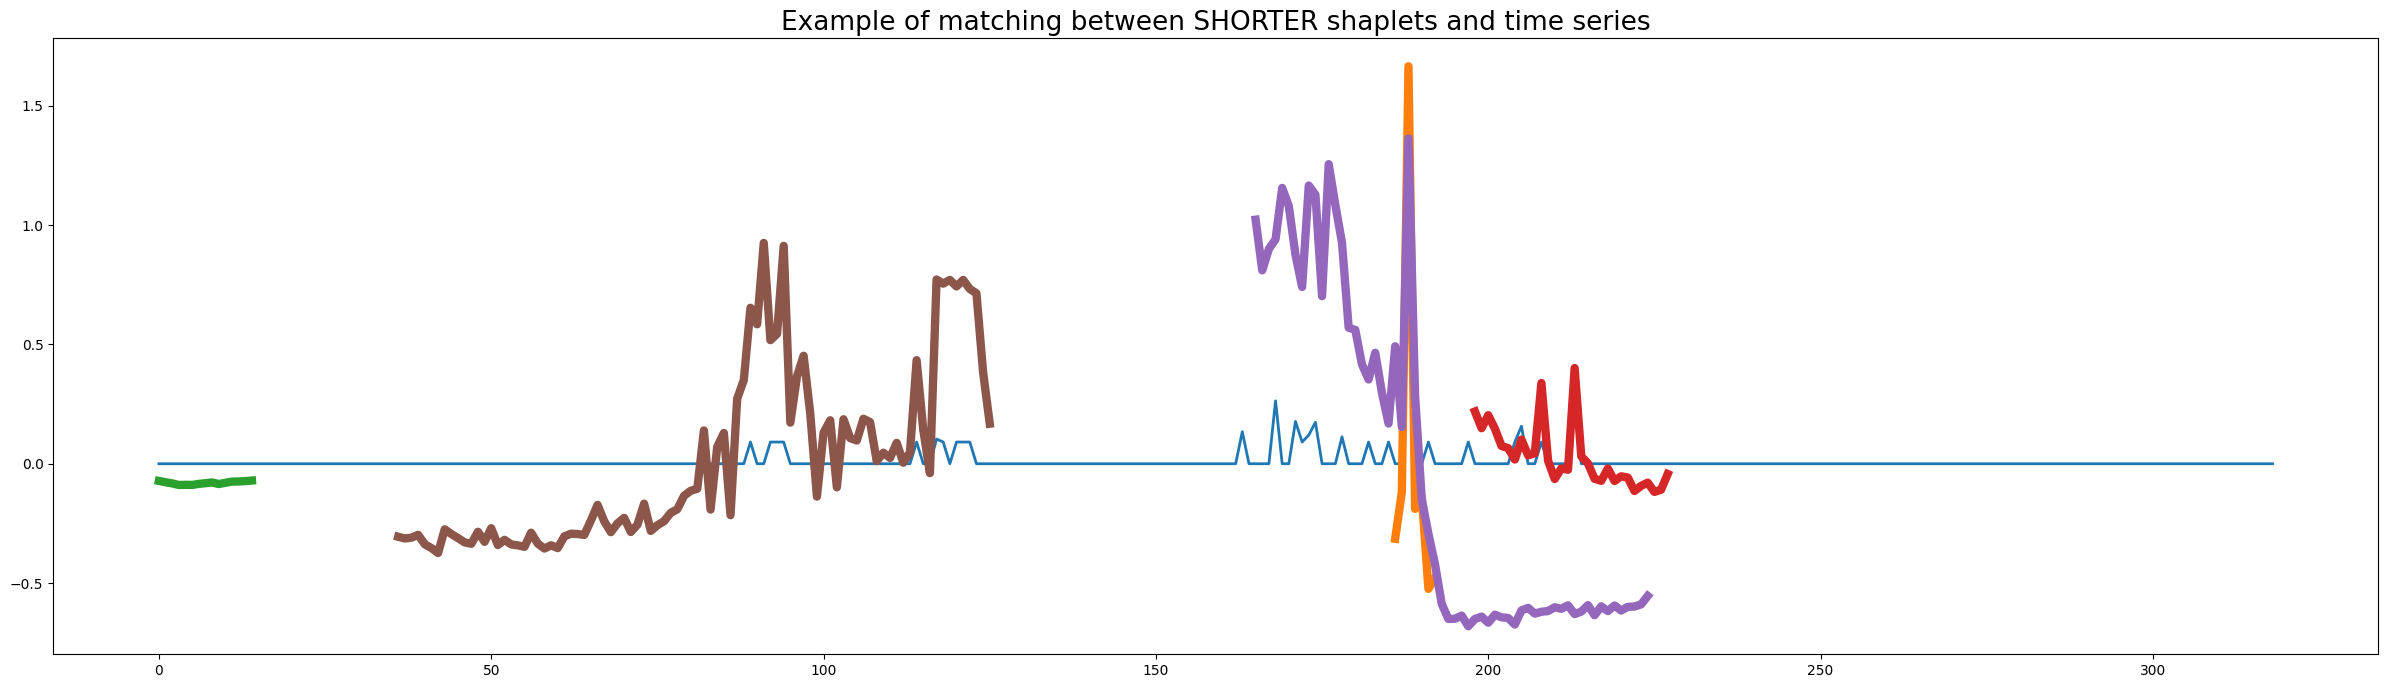

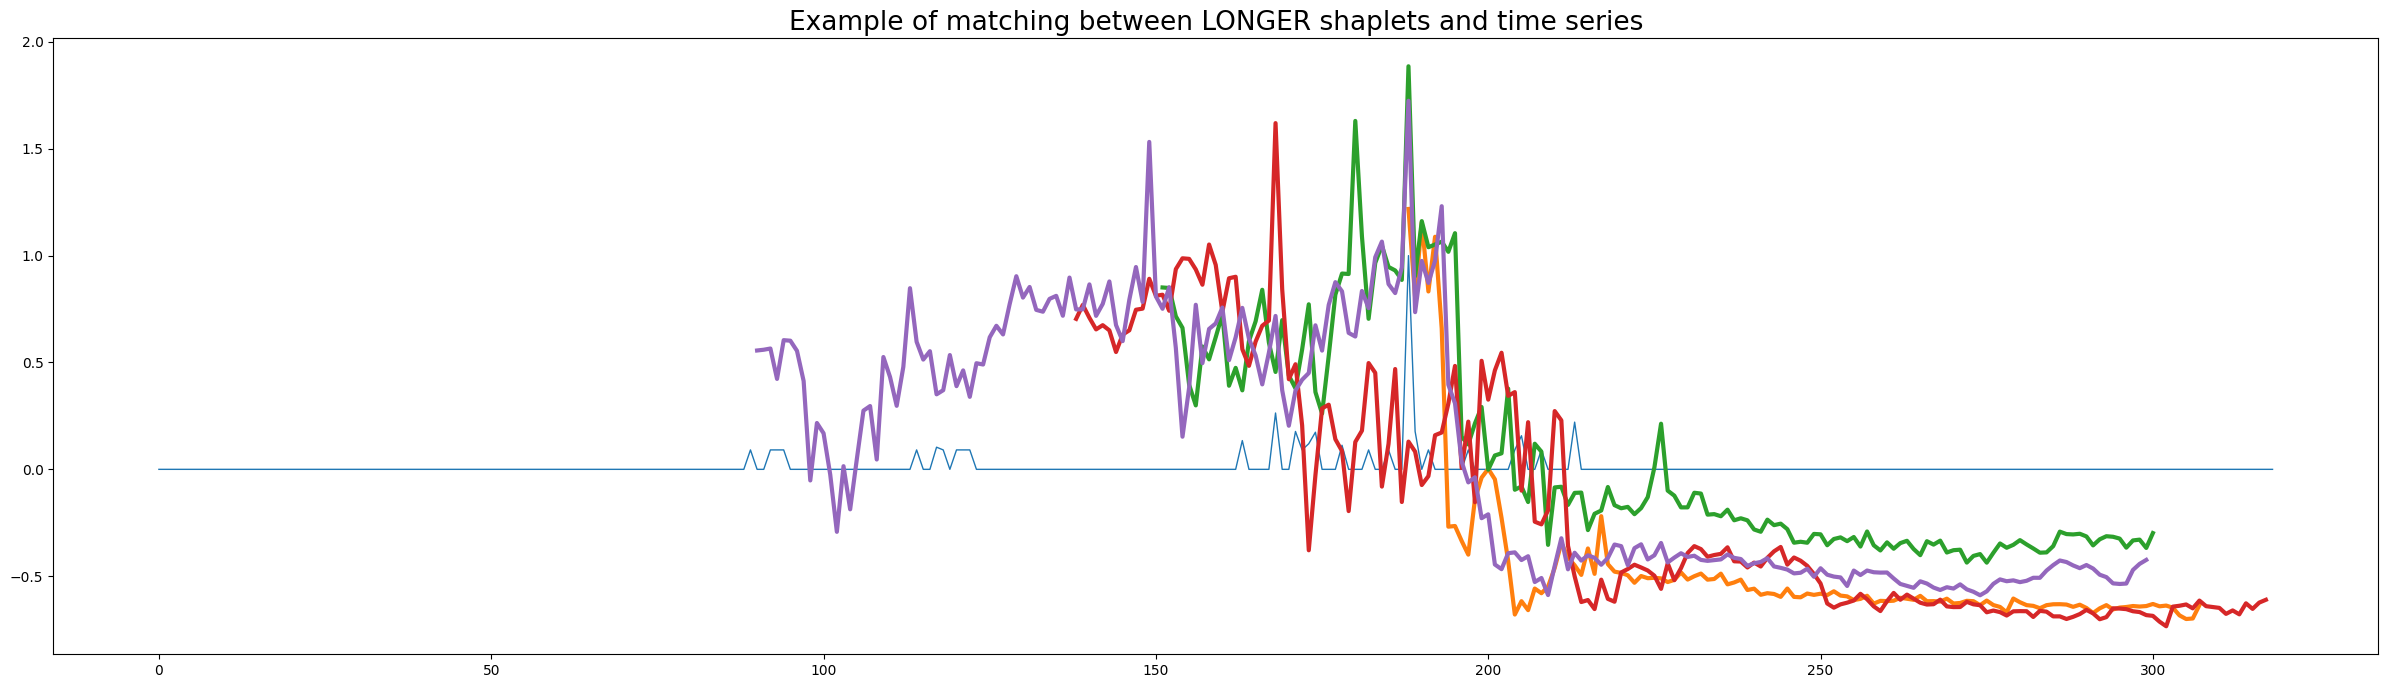

In [49]:
sample_id = 10

plt.figure(figsize=(30,8))
plt.plot(test_norm[sample_id], linewidth=2)

s = shp_clf.shapelets_.tolist()
n_items = [item for item in shapelet_sizes.values()]
index = 0

h = int(len(n_items)/2)

plt.title("Example of matching between SHORTER shaplets and time series", fontsize=19)
for i in range(h): 
    t0 = predicted_locations[sample_id, index]
    plt.plot(np.arange(t0, t0 + len(s[index])), s[index], linewidth=6)
    index = n_items[i] + index
plt.savefig('ShortShapelets.png')

plt.figure(figsize=(30,8))
plt.plot(test_norm[sample_id], linewidth=1)

plt.title("Example of matching between LONGER shaplets and time series", fontsize=19)
for i in range(h+1, len(n_items)): 
    t0 = predicted_locations[sample_id, index]
    plt.plot(np.arange(t0, t0 + len(s[index])), s[index], linewidth=3)
    index = n_items[i] + index
plt.savefig('LongShapelets.png')